In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [4]:
!pip install PyDrive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyDrive: filename=PyDrive-1.3.1-py3-none-any.whl size=27433 sha256=cb36488e10bc5e7680635a67f5a5ce40e7105b7c9c95a44ee75a13750790d0e5
  Stored in directory: /root/.cache/pip/wheels/6c/10/da/a5b513f5b3916fc391c20ee7b4633e5cf3396d570cdd74970f
Successfully built PyDrive


In [5]:
# General-purpose imports
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import quote
import webbrowser
import random
from collections import defaultdict
from base64 import b64decode

# Scikit-learn imports
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn imports
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,
    Input, GlobalAveragePooling2D, SeparableConv2D, Multiply
)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2

# For AdamW optimizer (if available)
try:
    from tensorflow.keras.optimizers import AdamW
except ImportError:
    AdamW = Adam

# IPython displays
from IPython.display import display

# Kerastuner imports
from kerastuner.tuners import RandomSearch

# Google Colab imports
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
import zipfile
import os

# Path to your ZIP file in Google Drive
zip_path = "/content/drive/MyDrive/fer2013/fer2013.zip"

# Destination folder where contents will be extracted
extract_path = "/content/fer2013"

# Extract the ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted folders/files
print(os.listdir(extract_path))

['test', 'train']


Found 22619 images belonging to 6 classes.
Found 5654 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.
Class weights: {0: np.float64(1.1795473508552357), 1: np.float64(1.1500406752084604), 2: np.float64(0.6531242781242781), 3: np.float64(0.9491020476670023), 4: np.float64(0.9756297446514838), 5: np.float64(1.4859414006043883)}
Building Stable VGG16 Model...
Building Stable DenseNet121 Model...

Stable VGG16 Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 48, 48, 3) │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 1, 1, 512) │ 14,714,688 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │     32,832 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 512)       │     33,280 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1, 512) │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1, 1, 512) │          0 │ vgg16[0][0],      │
│ (Multiply)          │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ multiply_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │    131,328 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     32,896 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 6)         │        774 │ dropout_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,949,382 (57.03 MB)

 Trainable params: 232,902 (909.77 KB)

 Non-trainable params: 14,716,480 (56.14 MB)


PHASE 1: Training with frozen base models

Training vgg16 (Frozen Base)...
Epoch 1/30
707/707 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1860 - loss: 2.5420
Epoch 1: val_accuracy improved from -inf to 0.25964, saving model to best_vgg16_phase1_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.1860 - loss: 2.5418 - val_accuracy: 0.2596 - val_loss: 1.8141 - learning_rate: 1.0000e-04
Epoch 2/30
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2208 - loss: 2.1705
Epoch 2: val_accuracy improved from 0.25964 to 0.28493, saving model to best_vgg16_phase1_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 69s 46ms/step - accuracy: 0.2208 - loss: 2.1704 - val_accuracy: 0.2849 - val_loss: 1.7574 - learning_rate: 1.0000e-04
Epoch 3/30
706/707 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2325 - loss: 2.0436
Epoch 3: val_accuracy improved from 0.28493 to 0.30704, saving model to best_vgg16_phase1_model.keras
707/707 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.2325 - lo

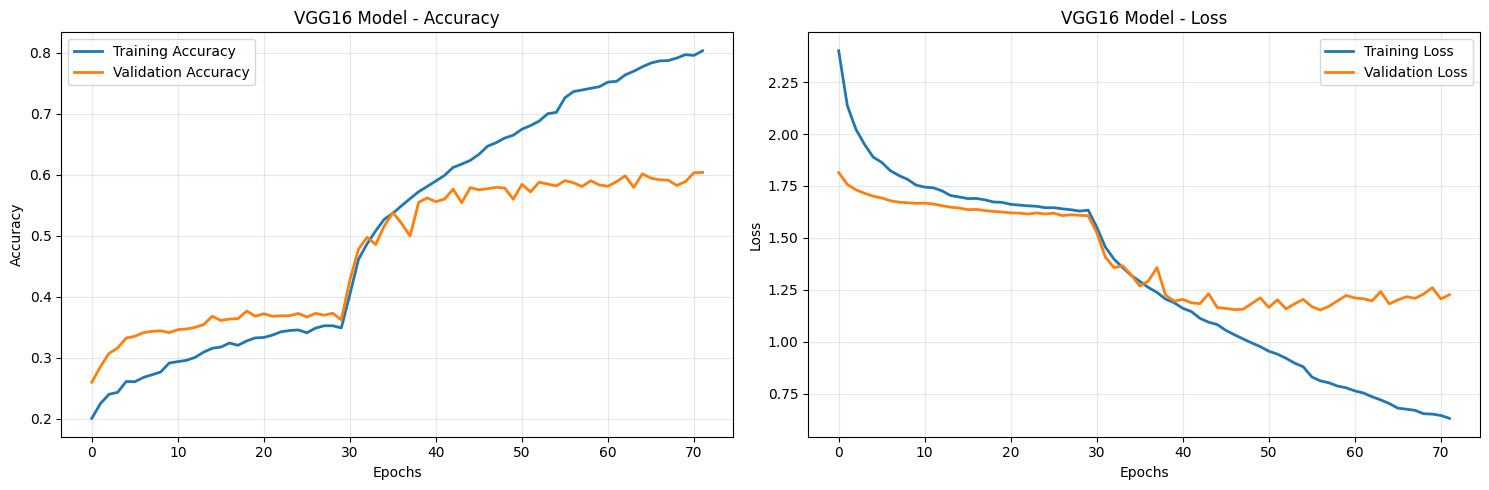

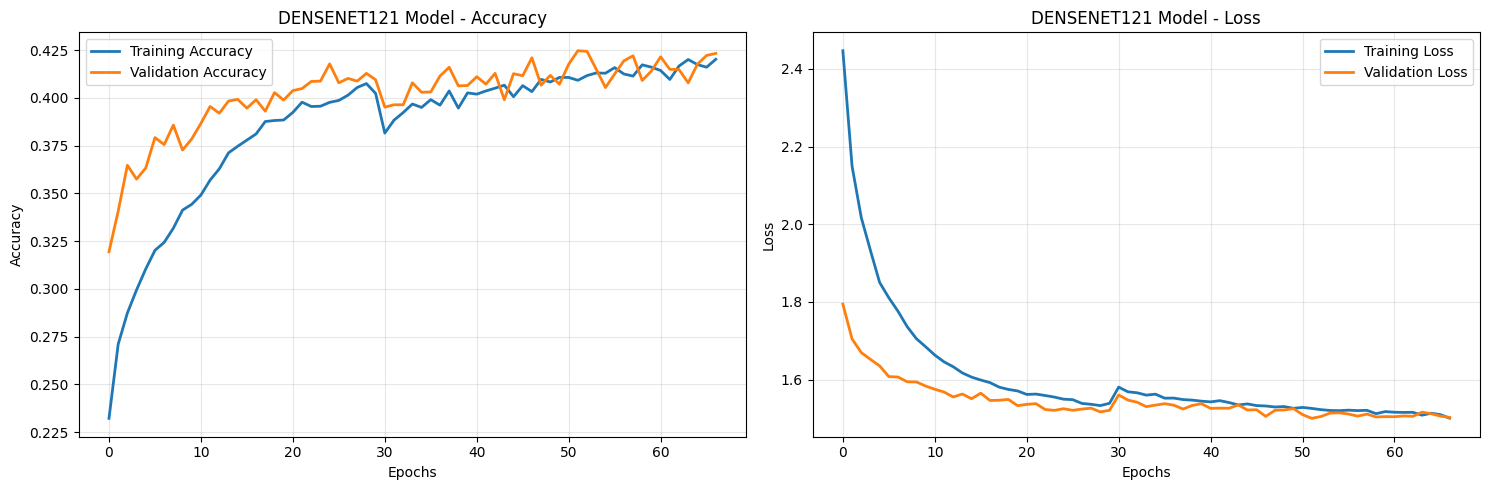


Evaluating Models...

Evaluating vgg16 Model...
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Classification Report for vgg16
              precision    recall  f1-score   support

       angry       0.52      0.58      0.55       958
        fear       0.53      0.44      0.48      1024
       happy       0.81      0.82      0.82      1774
     neutral       0.56      0.63      0.59      1233
         sad       0.53      0.48      0.50      1247
    surprise       0.76      0.76      0.76       831

    accuracy                           0.63      7067
   macro avg       0.62      0.62      0.62      7067
weighted avg       0.63      0.63      0.63      7067

221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6057 - loss: 1.1378

Evaluating densenet121 Model...
221/221 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step
Classification Report for densenet121
              precision    recall  f1-score   support

       angry       0.33      0.34      0.33       958
        fear       0.31      0.12  

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Multiply, Activation, Reshape, Permute, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import cv2
import warnings
warnings.filterwarnings('ignore')

# ---------------------------- Configurations ---------------------------- #
IMAGE_SIZE = 48
BATCH_SIZE = 32  # Reduced batch size for better stability
EPOCHS = 80

TRAIN_PATH = "/content/fer2013/train"
TEST_PATH = "/content/fer2013/test"
SELECTED_CLASSES = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# ---------------------------- Simplified Image Preprocessing ---------------------------- #
def simple_enhance_image(image):
    """
    Simplified but effective image enhancement
    """
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # 1. CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
    enhanced = clahe.apply(image)

    # 2. Mild Gaussian blur for noise reduction
    enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

    # Convert back to float32
    enhanced = enhanced.astype(np.float32) / 255.0

    return enhanced

def preprocess_function(image):
    """
    Simplified preprocessing function
    """
    enhanced_images = []
    for i in range(image.shape[-1]):
        enhanced_channel = simple_enhance_image(image[..., i])
        enhanced_images.append(enhanced_channel)

    enhanced_image = np.stack(enhanced_images, axis=-1)
    return enhanced_image

# ---------------------------- Simplified Attention Mechanisms ---------------------------- #
def simplified_channel_attention(input_tensor, reduction_ratio=8):
    """Simplified Channel Attention Module"""
    channels = input_tensor.shape[-1]

    # Global Average Pooling only (simpler)
    gap = GlobalAveragePooling2D()(input_tensor)
    gap = Dense(channels // reduction_ratio, activation='relu',
                kernel_regularizer=l2(1e-4))(gap)
    gap = Dense(channels, activation='sigmoid',
                kernel_regularizer=l2(1e-4))(gap)

    # Reshape and multiply with input
    attention = Reshape((1, 1, channels))(gap)
    return Multiply()([input_tensor, attention])

def simplified_cbam_attention(input_tensor, reduction_ratio=8):
    """Simplified CBAM attention"""
    # Channel attention only (remove spatial for stability)
    x = simplified_channel_attention(input_tensor, reduction_ratio)
    return x

# ---------------------------- Conservative Data Generators ---------------------------- #
def create_conservative_generators(train_path, test_path, img_size, batch_size, selected_classes):
    """Create data generators with conservative augmentation."""

    # Conservative augmentation for training
    train_preprocessor = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,  # Reduced rotation
        zoom_range=0.1,     # Reduced zoom
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.05,   # Reduced shear
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],  # Narrower range
        fill_mode='nearest',
        validation_split=0.2
        # Removed preprocessing_function for stability
    )

    # No augmentation for validation and test
    test_preprocessor = ImageDataGenerator(rescale=1./255)

    train_generator = train_preprocessor.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        classes=selected_classes,
        shuffle=True
    )

    validation_generator = train_preprocessor.flow_from_directory(
        train_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        classes=selected_classes,
        shuffle=False
    )

    test_generator = test_preprocessor.flow_from_directory(
        test_path,
        target_size=(img_size, img_size),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
        classes=selected_classes
    )

    return train_generator, validation_generator, test_generator

# ---------------------------- Stable Model Building ---------------------------- #
def build_stable_vgg16(input_shape, num_classes):
    """Build stable VGG16 model with strong regularization."""
    # Create base model
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through VGG16
    x = base_model(x, training=False)

    # Simplified attention
    x = simplified_cbam_attention(x, reduction_ratio=8)

    # Conservative classifier head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu',
              kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    x = Dense(128, activation='relu',
              kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def build_stable_densenet121(input_shape, num_classes):
    """Build stable DenseNet121 model."""
    # Create base model
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape[0], input_shape[1], 3)
    )

    # Freeze base model initially
    base_model.trainable = False

    # Create input for grayscale
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Convert grayscale to 3 channels
    x = tf.keras.layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1))(inputs)

    # Pass through DenseNet121
    x = base_model(x, training=False)

    # Simplified attention
    x = simplified_cbam_attention(x, reduction_ratio=16)

    # Conservative classifier head
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu',
              kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

def unfreeze_model_for_fine_tuning(model, base_model_name, learning_rate=1e-5):
    """Carefully unfreeze model for fine-tuning"""
    if base_model_name == 'vgg16':
        base_model = model.layers[2]  # VGG16 layer
        base_model.trainable = True
        # Unfreeze only the last 4 blocks
        for layer in base_model.layers[:-8]:
            layer.trainable = False
    else:  # densenet121
        base_model = model.layers[2]  # DenseNet121 layer
        base_model.trainable = True
        # Unfreeze only the last 20 layers
        for layer in base_model.layers[:-20]:
            layer.trainable = False

    # Recompile with lower learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ---------------------------- Enhanced Callbacks ---------------------------- #
def get_stable_callbacks(model_name):
    """Get callbacks for stable training."""
    checkpoint = ModelCheckpoint(
        f"best_{model_name}_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max',
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",  # Monitor val_loss instead
        patience=15,
        restore_best_weights=True,
        mode='min',
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=8,
        min_lr=1e-8,
        verbose=1
    )

    return [checkpoint, early_stopping, reduce_lr]

# ---------------------------- Training Strategy ---------------------------- #
def create_class_weights(generator):
    """Create balanced class weights."""
    class_counts = np.bincount(generator.classes)
    total_samples = np.sum(class_counts)
    num_classes = len(class_counts)

    class_weights = {}
    for i in range(num_classes):
        class_weights[i] = total_samples / (num_classes * class_counts[i])

    return class_weights

def plot_training_history(history, title):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ---------------------------- Main Training Pipeline ---------------------------- #
if __name__ == "__main__":
    # Use conservative generators
    train_generator, validation_generator, test_generator = create_conservative_generators(
        TRAIN_PATH, TEST_PATH, IMAGE_SIZE, BATCH_SIZE, SELECTED_CLASSES
    )

    # Calculate class weights
    class_weights = create_class_weights(train_generator)
    print("Class weights:", class_weights)

    # Build models (frozen base)
    print("Building Stable VGG16 Model...")
    vgg_model = build_stable_vgg16((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
    vgg_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    print("Building Stable DenseNet121 Model...")
    densenet_model = build_stable_densenet121((IMAGE_SIZE, IMAGE_SIZE, 1), len(SELECTED_CLASSES))
    densenet_model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Print model summaries
    print("\nStable VGG16 Model Summary:")
    vgg_model.summary()

    # Phase 1: Train with frozen base
    print("\n" + "="*60)
    print("PHASE 1: Training with frozen base models")
    print("="*60)

    models = {
        'vgg16': vgg_model,
        'densenet121': densenet_model
    }

    phase1_histories = {}

    for name, model in models.items():
        print(f"\nTraining {name} (Frozen Base)...")

        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=30,  # First phase: fewer epochs
            batch_size=BATCH_SIZE,
            callbacks=get_stable_callbacks(f"{name}_phase1"),
            class_weight=class_weights,
            verbose=1
        )
        phase1_histories[name] = history

    # Phase 2: Fine-tuning with unfrozen layers
    print("\n" + "="*60)
    print("PHASE 2: Fine-tuning with unfrozen layers")
    print("="*60)

    phase2_histories = {}

    for name, model in models.items():
        print(f"\nFine-tuning {name}...")

        # Unfreeze carefully
        model = unfreeze_model_for_fine_tuning(model, name, learning_rate=1e-5)

        history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=EPOCHS - 30,  # Remaining epochs
            batch_size=BATCH_SIZE,
            callbacks=get_stable_callbacks(f"{name}_phase2"),
            class_weight=class_weights,
            verbose=1
        )
        phase2_histories[name] = history

    # Combine histories
    combined_histories = {}
    for name in models.keys():
        combined_history = {}
        for key in phase1_histories[name].history.keys():
            combined_history[key] = (phase1_histories[name].history[key] +
                                   phase2_histories[name].history[key])
        combined_histories[name] = type('History', (), {'history': combined_history})

    # Plot training history
    print("\nPlotting Training Histories...")
    for name, history in combined_histories.items():
        plot_training_history(history, f"{name.upper()} Model")

    # Evaluate models
    results = {}
    print("\nEvaluating Models...")
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {name} Model...")
        print(f"{'='*50}")

        # Generate predictions
        predictions = model.predict(test_generator)
        pred_classes = np.argmax(predictions, axis=1)
        true_classes = test_generator.classes

        print(f"Classification Report for {name}")
        print(classification_report(true_classes, pred_classes, target_names=SELECTED_CLASSES))

        # Store results
        test_loss, test_acc = model.evaluate(test_generator)
        results[name] = {'accuracy': test_acc, 'loss': test_loss}

    # Compare model performances
    print("\n" + "="*60)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*60)
    for name, result in results.items():
        print(f"{name.upper():<20} - Test Accuracy: {result['accuracy']:.4f}, Test Loss: {result['loss']:.4f}")

    # Find best model
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    print(f"\n🎯 BEST MODEL: {best_model_name.upper()} with accuracy: {results[best_model_name]['accuracy']:.4f}")

    # Save models
    print("\nSaving models...")
    for name, model in models.items():
        model.save(f'fer_stable_{name}_model.keras')
        print(f"Saved: fer_stable_{name}_model.keras")

    print("All models saved successfully!")